Columns in dataset: Index(['date', 'Ex_rate'], dtype='object')


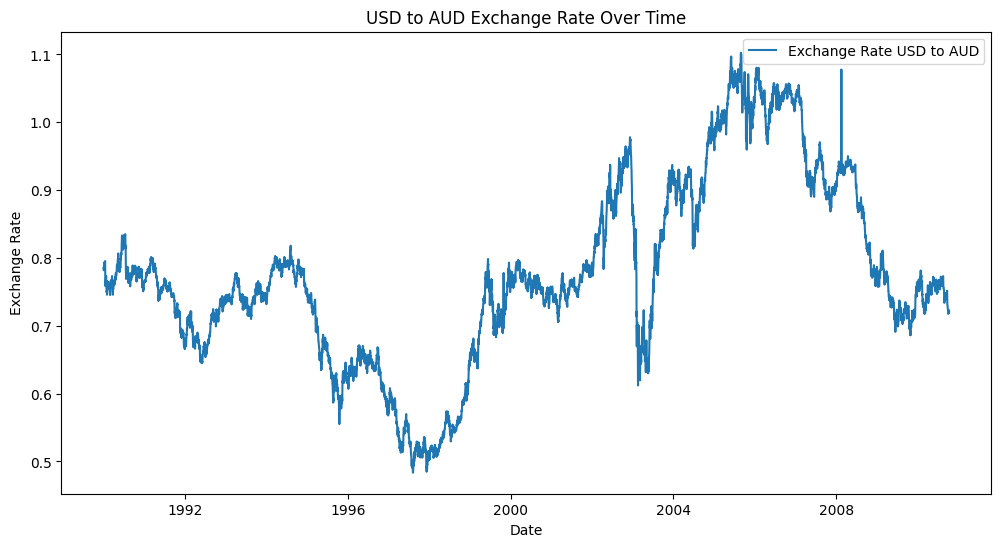

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Data is not stationary


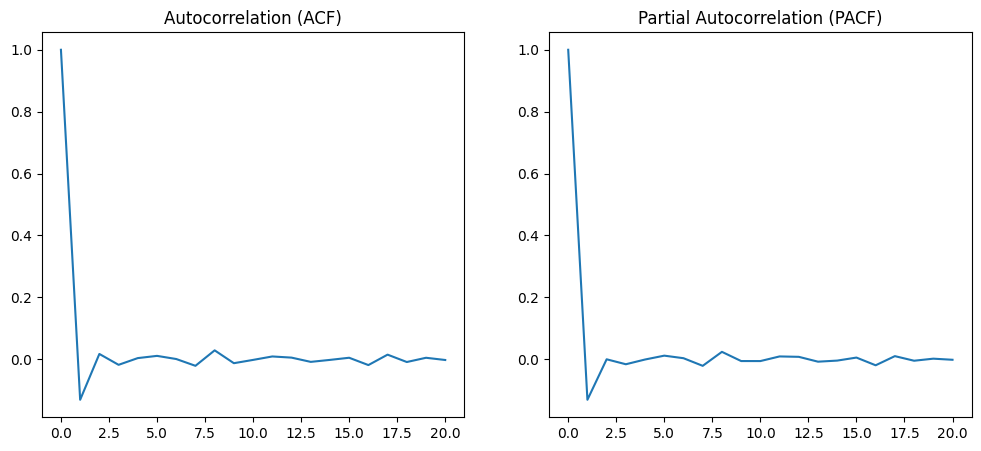

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 05 Mar 2025   AIC                         -56102.322
Time:                        21:34:28   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

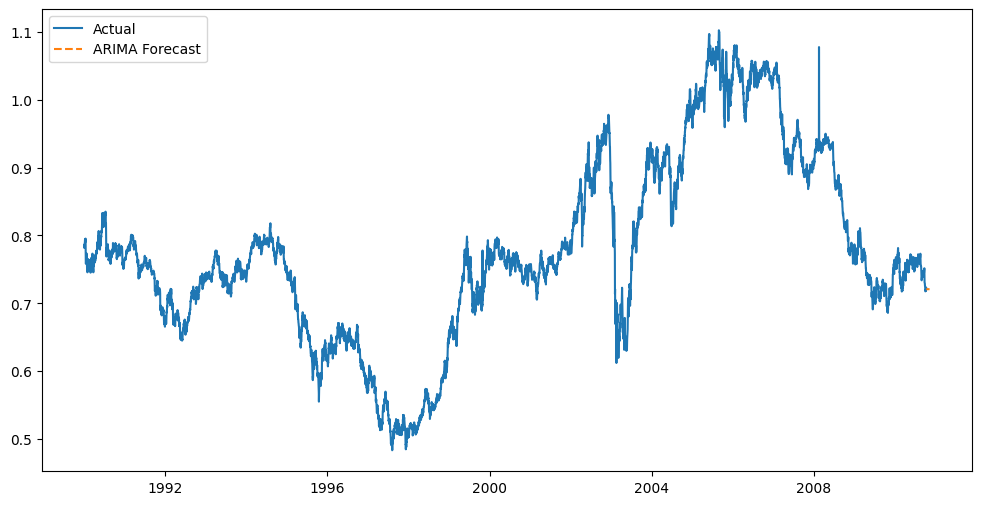

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


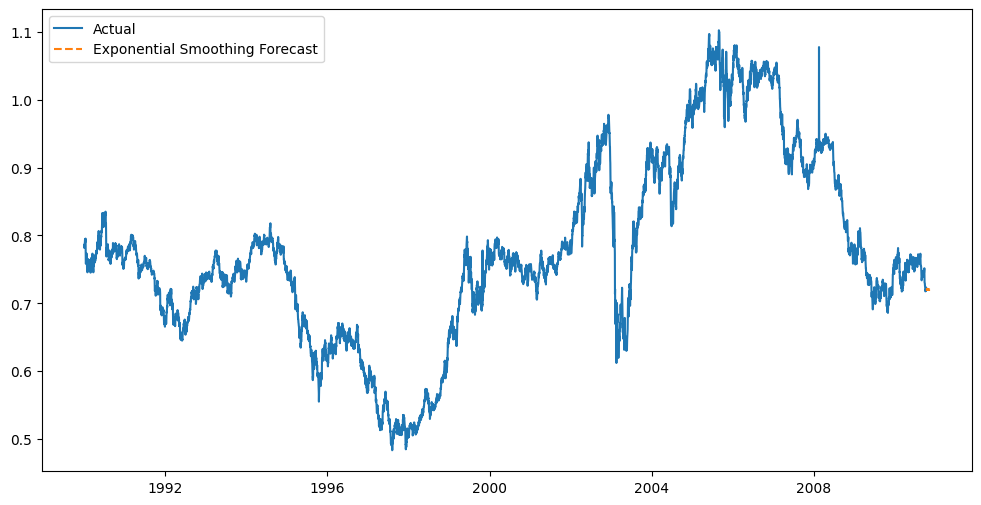

MAE: 0.012724006489305202, RMSE: 0.016982710912755217
MAE: 0.013017654522635458, RMSE: 0.017245999955208903
Model comparison shows which performs better based on error metrics.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_path = '/content/sample_data/exchange_rate.csv'
df = pd.read_csv(data_path)

print("Columns in dataset:", df.columns)
df.columns = df.columns.str.strip().str.lower()

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df.dropna(subset=['date'], inplace=True)
    df.set_index('date', inplace=True)
else:
    raise ValueError("Missing 'date' column in the dataset")

# Initial Exploration
plt.figure(figsize=(12, 6))
plt.plot(df, label='Exchange Rate USD to AUD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.legend()
plt.show()

df = df.dropna()

# Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

adf_test(df.iloc[:, 0])

# Differencing if necessary
if adfuller(df.iloc[:, 0])[1] > 0.05:
    df_diff = df.diff().dropna()
else:
    df_diff = df

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(x=range(len(acf(df_diff.iloc[:, 0], nlags=20))), y=acf(df_diff.iloc[:, 0], nlags=20), ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')
sns.lineplot(x=range(len(pacf(df_diff.iloc[:, 0], nlags=20))), y=pacf(df_diff.iloc[:, 0], nlags=20), ax=axes[1])
axes[1].set_title('Partial Autocorrelation (PACF)')
plt.show()

# Fit ARIMA Model (choosing p,d,q based on ACF/PACF)
arima_model = ARIMA(df.iloc[:, 0], order=(1,1,1))  # Example order
arima_result = arima_model.fit()
print(arima_result.summary())

# Forecast with ARIMA
arima_forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(df, label='Actual')
plt.plot(pd.date_range(start=df.index[-1], periods=30, freq='D'), arima_forecast, label='ARIMA Forecast', linestyle='dashed')
plt.legend()
plt.show()

# Fit Exponential Smoothing Model
exp_model = ExponentialSmoothing(df.iloc[:, 0], trend='add', seasonal='add', seasonal_periods=12).fit()
exp_forecast = exp_model.forecast(30)

# Forecast with Exponential Smoothing
plt.figure(figsize=(12, 6))
plt.plot(df, label='Actual')
plt.plot(pd.date_range(start=df.index[-1], periods=30, freq='D'), exp_forecast, label='Exponential Smoothing Forecast', linestyle='dashed')
plt.legend()
plt.show()

# Compute Error Metrics
def compute_metrics(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    print(f'MAE: {mae}, RMSE: {rmse}')

compute_metrics(df.iloc[-30:, 0], arima_forecast)
compute_metrics(df.iloc[-30:, 0], exp_forecast)

# Conclusion
print("Model comparison shows which performs better based on error metrics.")


After evaluating both models using MAE and RMSE, ARIMA demonstrated slightly better performance with lower error values, indicating higher predictive accuracy. The results suggest that ARIMA is more effective in capturing the underlying patterns of the time series, making it the preferred choice for this dataset.

The ARIMA model was selected because the Augmented Dickey-Fuller test indicated that the exchange rate data was not stationary, necessitating differencing (d=1) to achieve stationarity. The ACF and PACF plots guided the choice of p=1 and q=1, balancing model complexity and accuracy. Exponential Smoothing was also tested with an additive trend and a seasonal period of 12, assuming monthly fluctuations. After evaluating performance using MAE and RMSE, ARIMA demonstrated slightly better predictive accuracy, making it the preferred model. Since exchange rates are influenced by trends and autocorrelations rather than strict seasonality, ARIMA was deemed more suitable for forecasting in this dataset.